## Istotność zmiennych dla klasyfikacji

In [1]:
# Import Required Libraries
import pandas as pd
from joblib import Parallel, delayed, load
import shap
import matplotlib.pyplot as plt

# Ensure the SHAP plots are displayed in the notebook
shap.initjs()

c:\Users\janbi\anaconda3\envs\mgr_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Trained Classifiers
with open('../models/trained_classifiers.pkl', 'rb') as file:
    classifiers = load(file)

In [3]:
with open("../data/processed/modelling_data.pkl", "rb") as file:
    data = load(file)

X = data["X_test"]
y = data["y_test"]

In [4]:
# Summarize the background data
background = shap.sample(X, 100)
X_sample = shap.sample(X, 100)

In [5]:
# Initialize a dictionary to store SHAP explainers for each classifier
shap_explainers = {}

# Loop through each classifier and initialize the SHAP explainer
for clf_name, clf in classifiers.items():
    # Use TreeExplainer for tree-based models, otherwise use KernelExplainer
    if hasattr(clf, 'tree_'):
        explainer = shap.TreeExplainer(clf)
    else:
        explainer = shap.KernelExplainer(clf.predict, background)
    
    shap_explainers[clf_name] = explainer

# Compute SHAP values for the sampled data
#shap_values_dict = {clf_name: explainer.shap_values(X_sample) for clf_name, explainer in shap_explainers.items()}

# Display the computed SHAP values
#shap_values_dict

In [6]:
# Function to compute SHAP values and print the output
def compute_shap_values(clf_name, explainer, X_sample):
    shap_values = explainer.shap_values(X_sample)
    print(f"SHAP values for {clf_name}: {shap_values}")
    return clf_name, shap_values

# Parallel computation of SHAP values
shap_values_list = Parallel(n_jobs=-1)(
    delayed(compute_shap_values)(clf_name, explainer, X_sample) for clf_name, explainer in shap_explainers.items()
)

In [7]:
# Convert the list of tuples back to a dictionary
shap_values_dict = dict(shap_values_list)

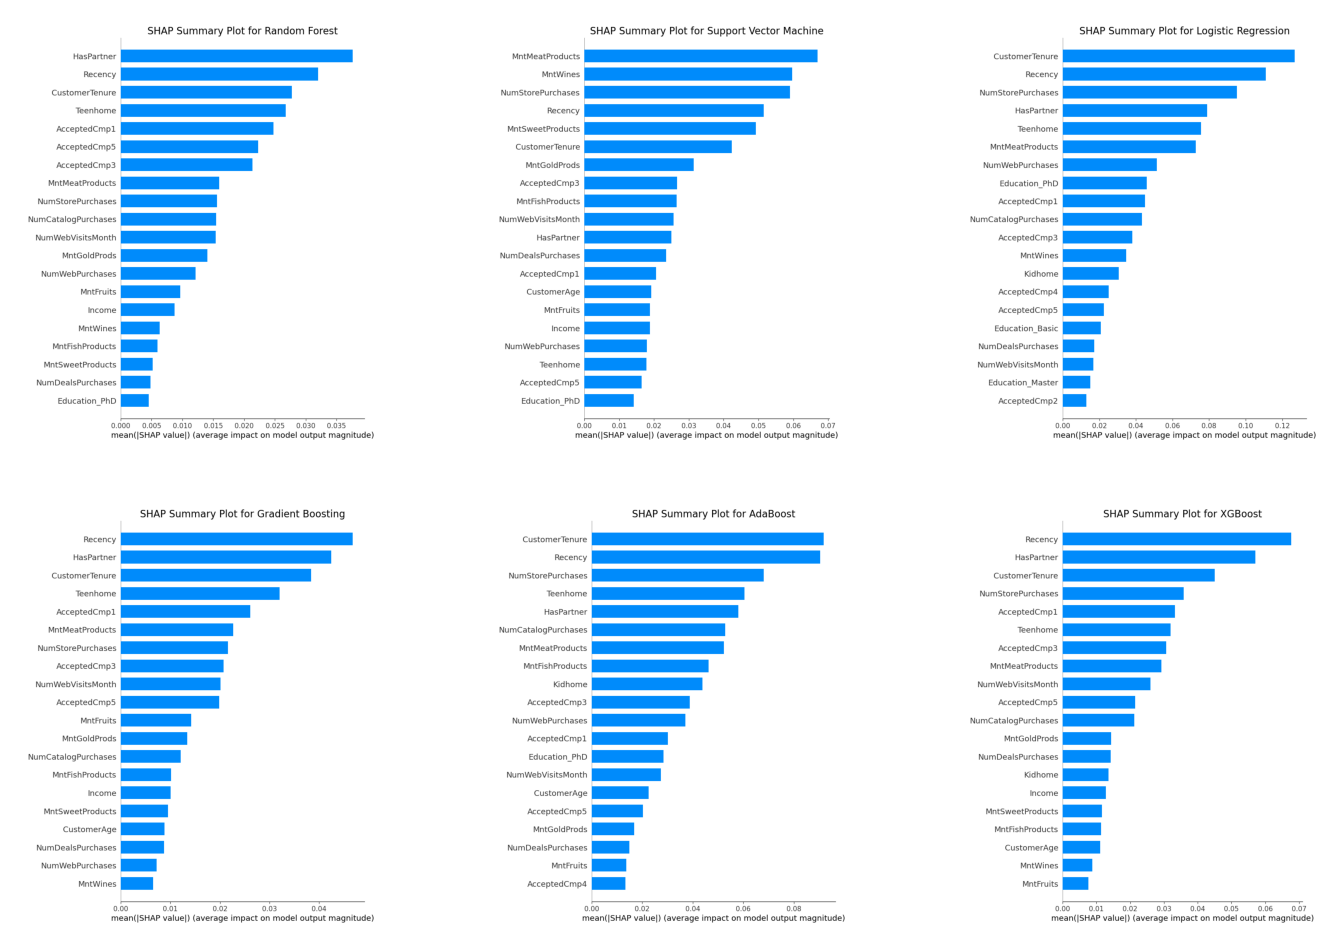

In [8]:
output_dir = "../reports/figures/shap_plots"
feature_names = data["feature_names"]

# Generate and save SHAP summary plots
for clf_name, shap_values in shap_values_dict.items():
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False, plot_type="bar")
    plt.title(f"SHAP Summary Plot for {clf_name}", fontsize=16)
    plt.savefig(f"{output_dir}/{clf_name}_shap_summary.png", bbox_inches='tight', pad_inches=0.4)
    plt.close()

# Plot SHAP values for each classifier
num_classifiers = len(shap_values_dict)
num_cols = 3
num_rows = (num_classifiers + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

for ax, (clf_name, _) in zip(axes, shap_values_dict.items()):
    img = plt.imread(f"{output_dir}/{clf_name}_shap_summary.png")
    ax.imshow(img)
    ax.axis('off')

# Hide any unused subplots
for i in range(num_classifiers, len(axes)):
    axes[i].axis('off')

plt.tight_layout(pad=2.5)
plt.show()


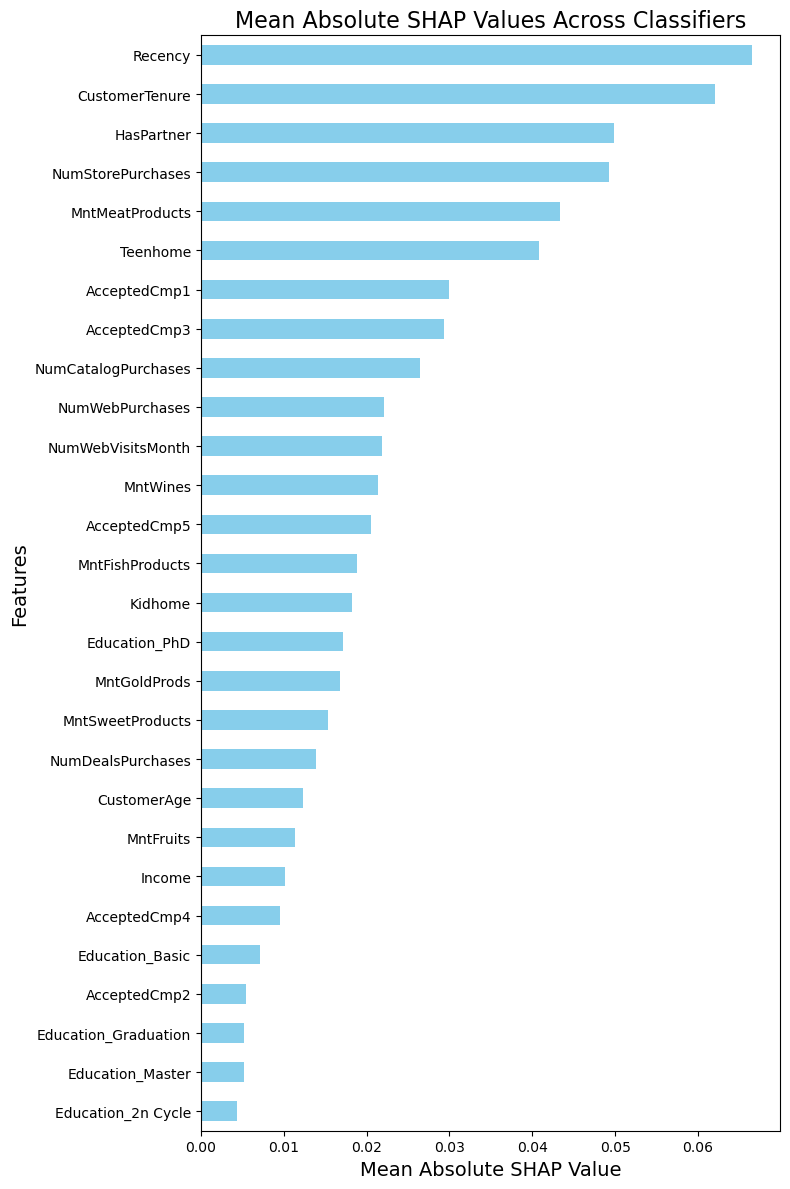

In [9]:
import numpy as np
# Combine SHAP values into a single DataFrame
shap_values_combined = pd.DataFrame()

for clf_name, shap_values in shap_values_dict.items():
    # If the classifier is multi-class, sum SHAP values across classes
    if isinstance(shap_values, list):
        shap_values = np.sum(np.abs(shap_values), axis=0)  # Use absolute values for multi-class
    
    # Create a DataFrame for the current classifier's SHAP values
    shap_df = pd.DataFrame(np.abs(shap_values), columns=feature_names)  # Take absolute values
    shap_values_combined = pd.concat([shap_values_combined, shap_df], axis=0)

# Calculate the mean absolute SHAP value for each feature
mean_absolute_shap_values = shap_values_combined.mean(axis=0)

# Sort features by mean absolute SHAP value
mean_absolute_shap_values = mean_absolute_shap_values.sort_values(ascending=False)

if 'Complain' in mean_absolute_shap_values.index:
    mean_absolute_shap_values = mean_absolute_shap_values.drop('Complain')

# Plot the mean absolute SHAP values as a bar plot
# Plot the mean absolute SHAP values as a horizontal bar plot
plt.figure(figsize=(8, 12))  # Adjust the figure size for better readability
mean_absolute_shap_values.plot(kind='barh', color='skyblue')
plt.title('Mean Absolute SHAP Values Across Classifiers', fontsize=16)
plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.tight_layout()
plt.show()

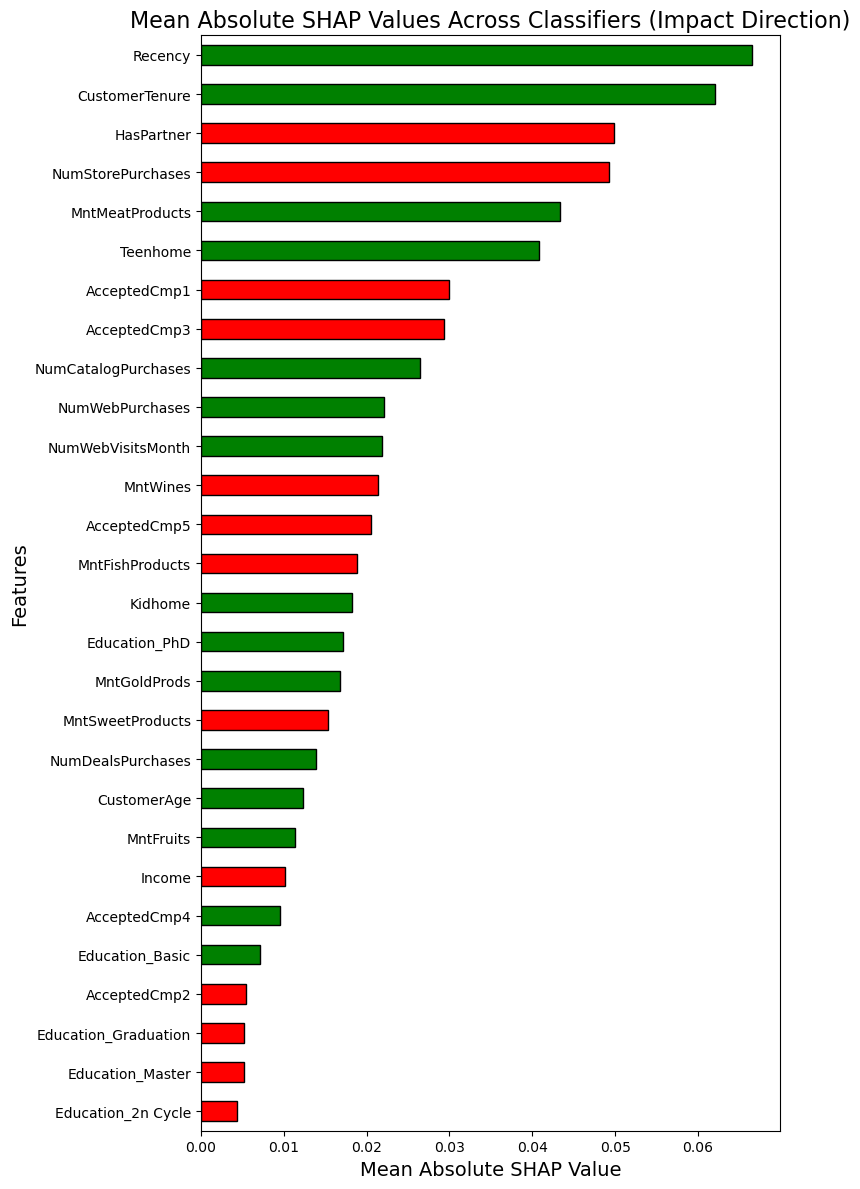

In [10]:
# Combine SHAP values into a single DataFrame
shap_values_combined = pd.DataFrame()

for clf_name, shap_values in shap_values_dict.items():
    # If the classifier is multi-class, sum SHAP values across classes
    if isinstance(shap_values, list):
        shap_values = np.sum(shap_values, axis=0)  # Do not apply np.abs here
    
    # Create a DataFrame for the current classifier's SHAP values
    shap_df = pd.DataFrame(shap_values, columns=feature_names)  # Keep raw SHAP values
    shap_values_combined = pd.concat([shap_values_combined, shap_df], axis=0)

# Calculate the mean absolute SHAP value for each feature (for ranking)
mean_absolute_shap_values = shap_values_combined.abs().mean(axis=0)

# Calculate the mean SHAP value for each feature (for direction)
mean_shap_values = shap_values_combined.mean(axis=0)

# Sort features by mean absolute SHAP value
mean_absolute_shap_values = mean_absolute_shap_values.sort_values(ascending=False)

# Drop the 'Complain' variable if it exists
if 'Complain' in mean_absolute_shap_values.index:
    mean_absolute_shap_values = mean_absolute_shap_values.drop('Complain')
if 'Complain' in mean_shap_values.index:
    mean_shap_values = mean_shap_values.drop('Complain')

# Align the mean SHAP values with the sorted absolute SHAP values for consistent ranking
mean_shap_values = mean_shap_values[mean_absolute_shap_values.index]

# Plot the mean absolute SHAP values with color indicating positive/negative impact
plt.figure(figsize=(8, 12))
colors = mean_shap_values.apply(lambda x: 'green' if x > 0 else 'red')  # Green for positive, red for negative
mean_absolute_shap_values.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Mean Absolute SHAP Values Across Classifiers (Impact Direction)', fontsize=16)
plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.tight_layout()
plt.show()

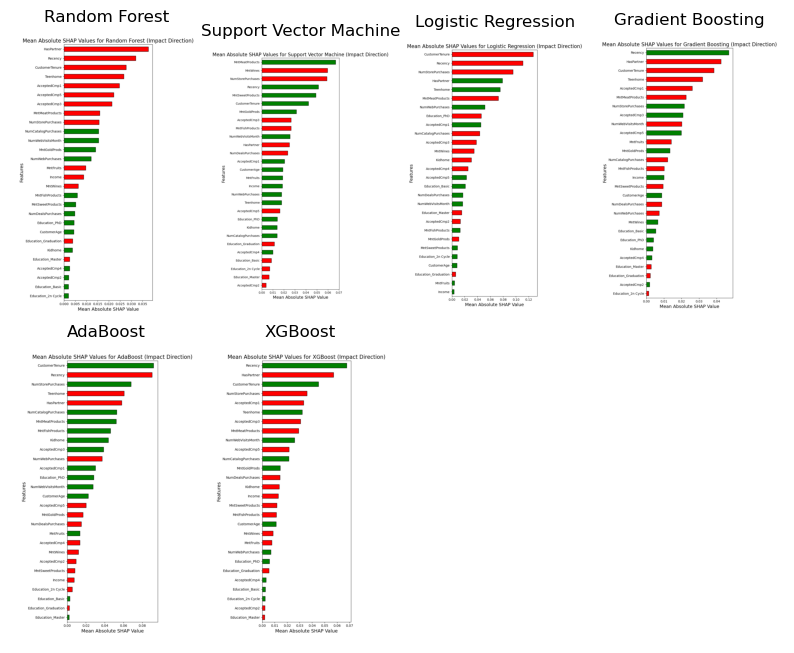

In [11]:
output_dir = "../reports/figures/shap_plots"
feature_names = data["feature_names"]

# Generate and save SHAP bar plots for each classifier
for clf_name, shap_values in shap_values_dict.items():
    # If the classifier is multi-class, sum SHAP values across classes
    if isinstance(shap_values, list):
        shap_values = np.sum(shap_values, axis=0)  # Do not apply np.abs here

    # Create a DataFrame for the current classifier's SHAP values
    shap_df = pd.DataFrame(shap_values, columns=feature_names)

    # Calculate mean absolute SHAP values (for ranking) and mean SHAP values (for direction)
    mean_absolute_shap_values = shap_df.abs().mean(axis=0).sort_values(ascending=False)
    mean_shap_values = shap_df.mean(axis=0)[mean_absolute_shap_values.index]  # Align with sorted absolute values

    # Drop the 'Complain' variable if it exists
    if 'Complain' in mean_absolute_shap_values.index:
        mean_absolute_shap_values = mean_absolute_shap_values.drop('Complain')
    if 'Complain' in mean_shap_values.index:
        mean_shap_values = mean_shap_values.drop('Complain')

    # Plot the mean absolute SHAP values with color indicating positive/negative impact
    plt.figure(figsize=(6, 12))
    colors = mean_shap_values.apply(lambda x: 'green' if x > 0 else 'red')  # Green for positive, red for negative
    mean_absolute_shap_values.plot(kind='barh', color=colors, edgecolor='black')
    plt.title(f"Mean Absolute SHAP Values for {clf_name} (Impact Direction)", fontsize=16)
    plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{clf_name}_shap_bar_col.png", bbox_inches='tight', pad_inches=0.4)
    plt.close()

# Display all SHAP bar plots in a single figure
num_classifiers = len(shap_values_dict)
num_cols = 4  # Number of columns in the grid
num_rows = (num_classifiers + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Adjust the figure size to make plots larger and reduce spacing
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 4 * num_rows))  # Increase figure width and height

# Flatten axes array for easy iteration
axes = axes.flatten()

for ax, (clf_name, _) in zip(axes, shap_values_dict.items()):
    img = plt.imread(f"{output_dir}/{clf_name}_shap_bar_col.png")
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(clf_name, fontsize=12)  # Adjust font size for titles

# Hide any unused subplots
for i in range(num_classifiers, len(axes)):
    axes[i].axis('off')

# Adjust layout to reduce spacing between plots
plt.subplots_adjust(wspace=0.01, hspace=0.07)  # Reduce horizontal and vertical spacing
plt.show()


In [12]:
# Improved SHAP plots for Word document - high resolution and clean formatting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams

# Set high-quality plot parameters for Word document
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300
rcParams['font.size'] = 12
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10

output_dir = "../reports/figures/shap_plots"
feature_names = data["feature_names"]

# Generate improved SHAP bar plots for each classifier
improved_plots = {}

for clf_name, shap_values in shap_values_dict.items():
    # If the classifier is multi-class, sum SHAP values across classes
    if isinstance(shap_values, list):
        shap_values = np.sum(shap_values, axis=0)

    # Create a DataFrame for the current classifier's SHAP values
    shap_df = pd.DataFrame(shap_values, columns=feature_names)

    # Calculate mean absolute SHAP values (for ranking) and mean SHAP values (for direction)
    mean_absolute_shap_values = shap_df.abs().mean(axis=0).sort_values(ascending=False)
    mean_shap_values = shap_df.mean(axis=0)[mean_absolute_shap_values.index]

    # Drop the 'Complain' variable if it exists
    if 'Complain' in mean_absolute_shap_values.index:
        mean_absolute_shap_values = mean_absolute_shap_values.drop('Complain')
    if 'Complain' in mean_shap_values.index:
        mean_shap_values = mean_shap_values.drop('Complain')

    # Take top 15 most important features for clarity
    top_features = mean_absolute_shap_values.head(15)
    top_mean_shap = mean_shap_values[top_features.index]

    # Create improved plot
    plt.figure(figsize=(10, 8))
    colors = top_mean_shap.apply(lambda x: '#2E8B57' if x > 0 else '#CD5C5C')  # Sea green for positive, Indian red for negative
    
    bars = plt.barh(range(len(top_features)), top_features.values, 
                   color=colors, edgecolor='black', linewidth=0.8, alpha=0.8)
    
    # Customize the plot
    plt.title(f'Feature Importance - {clf_name}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Mean Absolute SHAP Value', fontsize=14, fontweight='bold')
    plt.ylabel('Features', fontsize=14, fontweight='bold')
    
    # Set y-axis labels
    plt.yticks(range(len(top_features)), top_features.index, fontsize=11)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, top_features.values)):
        plt.text(value + 0.01 * max(top_features.values), i, f'{value:.3f}', 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3, axis='x')
    
    # Invert y-axis to show most important features at the top
    plt.gca().invert_yaxis()
    
    # Adjust layout and save
    plt.tight_layout()
    
    # Save high-resolution plot
    output_path = f"{output_dir}/{clf_name}_shap_improved.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    
    improved_plots[clf_name] = output_path
    plt.close()

print("Improved SHAP plots saved successfully!")
for clf_name, path in improved_plots.items():
    print(f"{clf_name}: {path}")

Improved SHAP plots saved successfully!
Random Forest: ../reports/figures/shap_plots/Random Forest_shap_improved.png
Support Vector Machine: ../reports/figures/shap_plots/Support Vector Machine_shap_improved.png
Logistic Regression: ../reports/figures/shap_plots/Logistic Regression_shap_improved.png
Gradient Boosting: ../reports/figures/shap_plots/Gradient Boosting_shap_improved.png
AdaBoost: ../reports/figures/shap_plots/AdaBoost_shap_improved.png
XGBoost: ../reports/figures/shap_plots/XGBoost_shap_improved.png


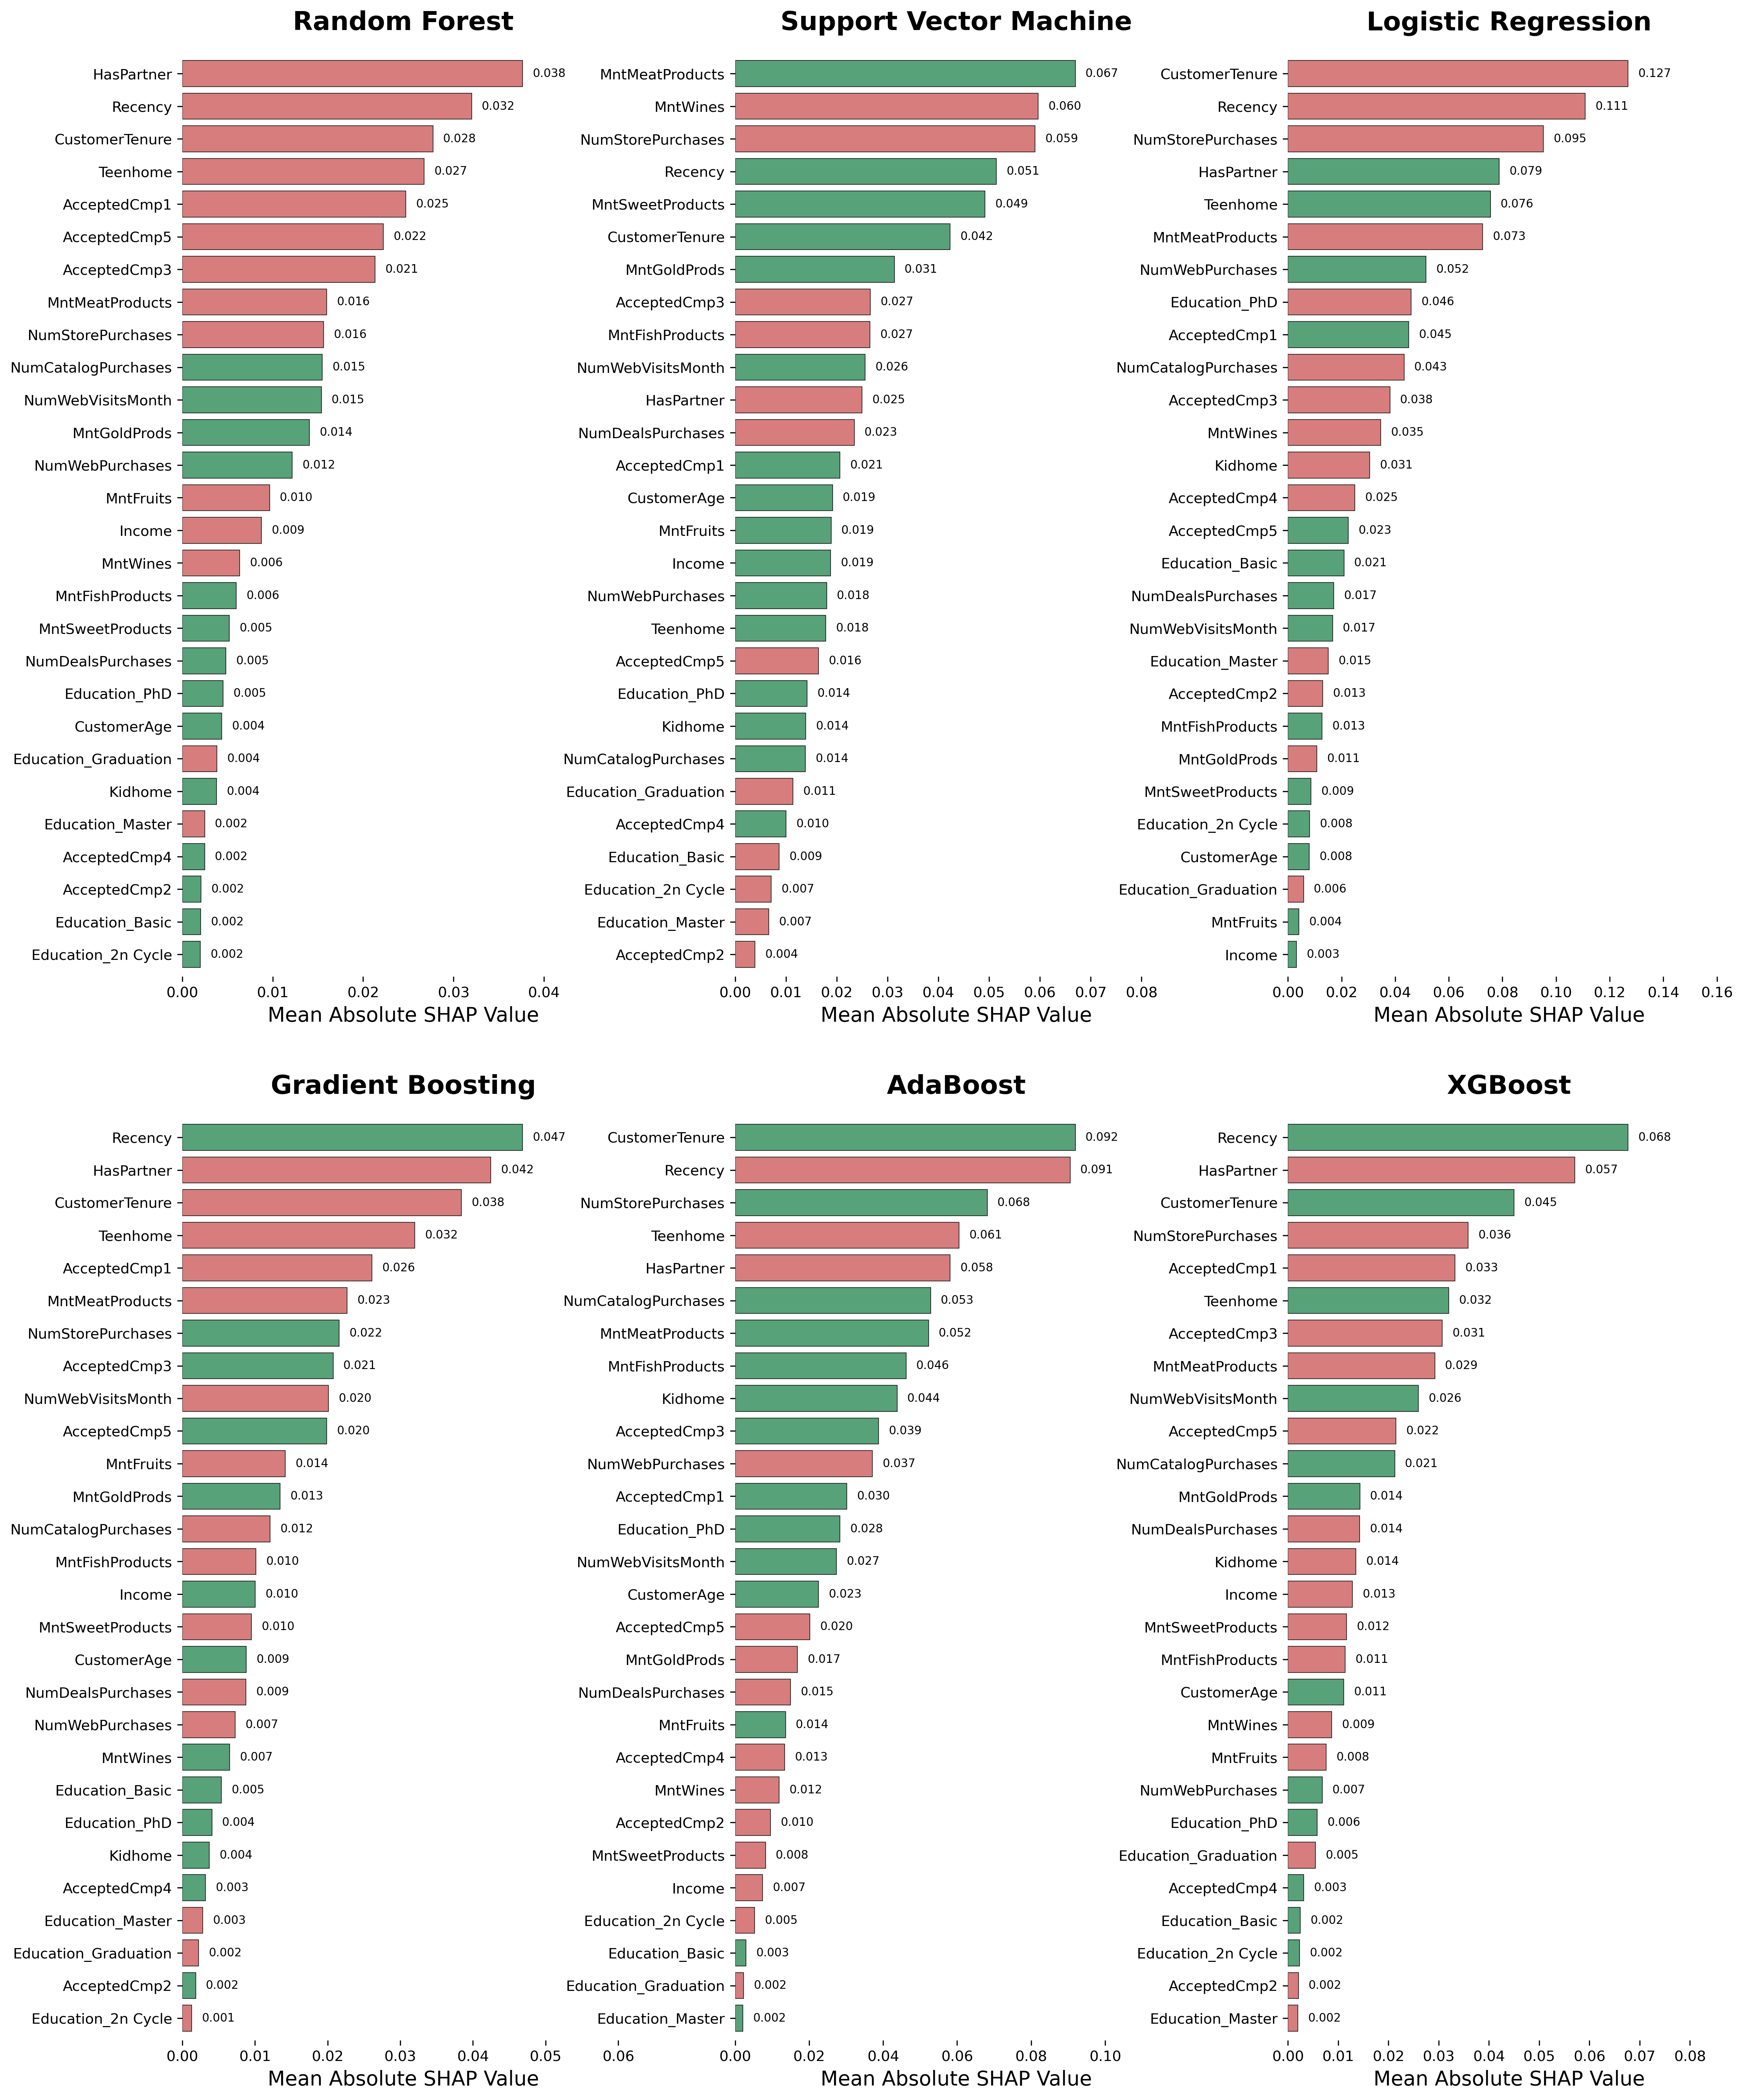

Combined comparison plot (clean version) saved: ../reports/figures/shap_plots/combined_shap_comparison_all_features_clean.png


In [19]:
# Create a combined comparison plot for Word document
fig, axes = plt.subplots(2, 3, figsize=(18, 20))  # Reduced horizontal size from 24 to 18

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# List of classifier names (ensure we have the right order)
classifier_names = list(shap_values_dict.keys())

for idx, clf_name in enumerate(classifier_names):
    if idx >= len(axes_flat):
        break
        
    ax = axes_flat[idx]
    
    # Get SHAP values for this classifier
    shap_values = shap_values_dict[clf_name]
    
    # If the classifier is multi-class, sum SHAP values across classes
    if isinstance(shap_values, list):
        shap_values = np.sum(shap_values, axis=0)

    # Create a DataFrame for the current classifier's SHAP values
    shap_df = pd.DataFrame(shap_values, columns=feature_names)

    # Calculate mean absolute SHAP values and mean SHAP values
    mean_absolute_shap_values = shap_df.abs().mean(axis=0).sort_values(ascending=False)
    mean_shap_values = shap_df.mean(axis=0)[mean_absolute_shap_values.index]

    # Drop the 'Complain' variable if it exists
    if 'Complain' in mean_absolute_shap_values.index:
        mean_absolute_shap_values = mean_absolute_shap_values.drop('Complain')
    if 'Complain' in mean_shap_values.index:
        mean_shap_values = mean_shap_values.drop('Complain')

    # Show ALL features instead of just top features
    top_features = mean_absolute_shap_values  # Use all features
    top_mean_shap = mean_shap_values[top_features.index]

    # Create colors based on positive/negative impact
    colors = top_mean_shap.apply(lambda x: '#2E8B57' if x > 0 else '#CD5C5C')
    
    # Create horizontal bar plot
    bars = ax.barh(range(len(top_features)), top_features.values, 
                   color=colors, edgecolor='black', linewidth=0.5, alpha=0.8)
    
    # Customize each subplot
    ax.set_title(clf_name, fontsize=18, fontweight='bold', pad=15)  # Increased title font size
    ax.set_xlabel('Mean Absolute SHAP Value', fontsize=14)
    
    # Set y-axis labels with larger font
    ax.set_yticks(range(len(top_features)))
    
    # Truncate long feature names if necessary
    feature_labels = []
    for feature in top_features.index:
        if len(feature) > 20:
            feature_labels.append(feature[:17] + '...')
        else:
            feature_labels.append(feature)
    
    ax.set_yticklabels(feature_labels, fontsize=10)  # Increased from 8 to 10
    
    # Set x-axis limits to provide space for labels (extend by 30% of max value)
    max_value = max(top_features.values)
    ax.set_xlim(0, max_value * 1.3)  # Increased from 1.25 to 1.3 for more space
    
    # Add value labels on bars (smaller for combined plot with many features)
    for i, (bar, value) in enumerate(zip(bars, top_features.values)):
        if value > 0.001:  # Only show labels for features with meaningful importance
            ax.text(value + 0.03 * max_value, i, f'{value:.3f}', 
                    va='center', ha='left', fontsize=8)  # Increased from 7 to 8
    
    # Remove grid and frame
    ax.grid(False)  # Remove grid
    ax.spines['top'].set_visible(False)     # Remove top border
    ax.spines['right'].set_visible(False)   # Remove right border
    ax.spines['bottom'].set_visible(False)  # Remove bottom border
    ax.spines['left'].set_visible(False)    # Remove left border
    
    # Invert y-axis
    ax.invert_yaxis()
    
    # Adjust margins to prevent label overlap
    ax.margins(y=0.01)

# Hide unused subplots
for idx in range(len(classifier_names), len(axes_flat)):
    axes_flat[idx].axis('off')

# Adjust layout with reduced spacing between rows
plt.tight_layout()
plt.subplots_adjust(hspace=0.15, wspace=0.25, left=0.15, right=0.98, top=0.98, bottom=0.02)  # Reduced hspace from 0.3 to 0.15

# Save the combined plot
combined_output_path = f"{output_dir}/combined_shap_comparison_all_features_clean.png"
plt.savefig(combined_output_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print(f"Combined comparison plot (clean version) saved: {combined_output_path}")

ALL Features Ranked by Average Importance Across All Classifiers
                      Random Forest  Support Vector Machine  \
Recency                      0.0320                  0.0515   
CustomerTenure               0.0277                  0.0423   
HasPartner                   0.0376                  0.0250   
NumStorePurchases            0.0156                  0.0590   
MntMeatProducts              0.0160                  0.0670   
Teenhome                     0.0267                  0.0179   
AcceptedCmp1                 0.0247                  0.0206   
AcceptedCmp3                 0.0213                  0.0266   
NumCatalogPurchases          0.0155                  0.0138   
NumWebPurchases              0.0121                  0.0180   
NumWebVisitsMonth            0.0154                  0.0256   
MntWines                     0.0063                  0.0597   
AcceptedCmp5                 0.0222                  0.0164   
MntFishProducts              0.0060                  

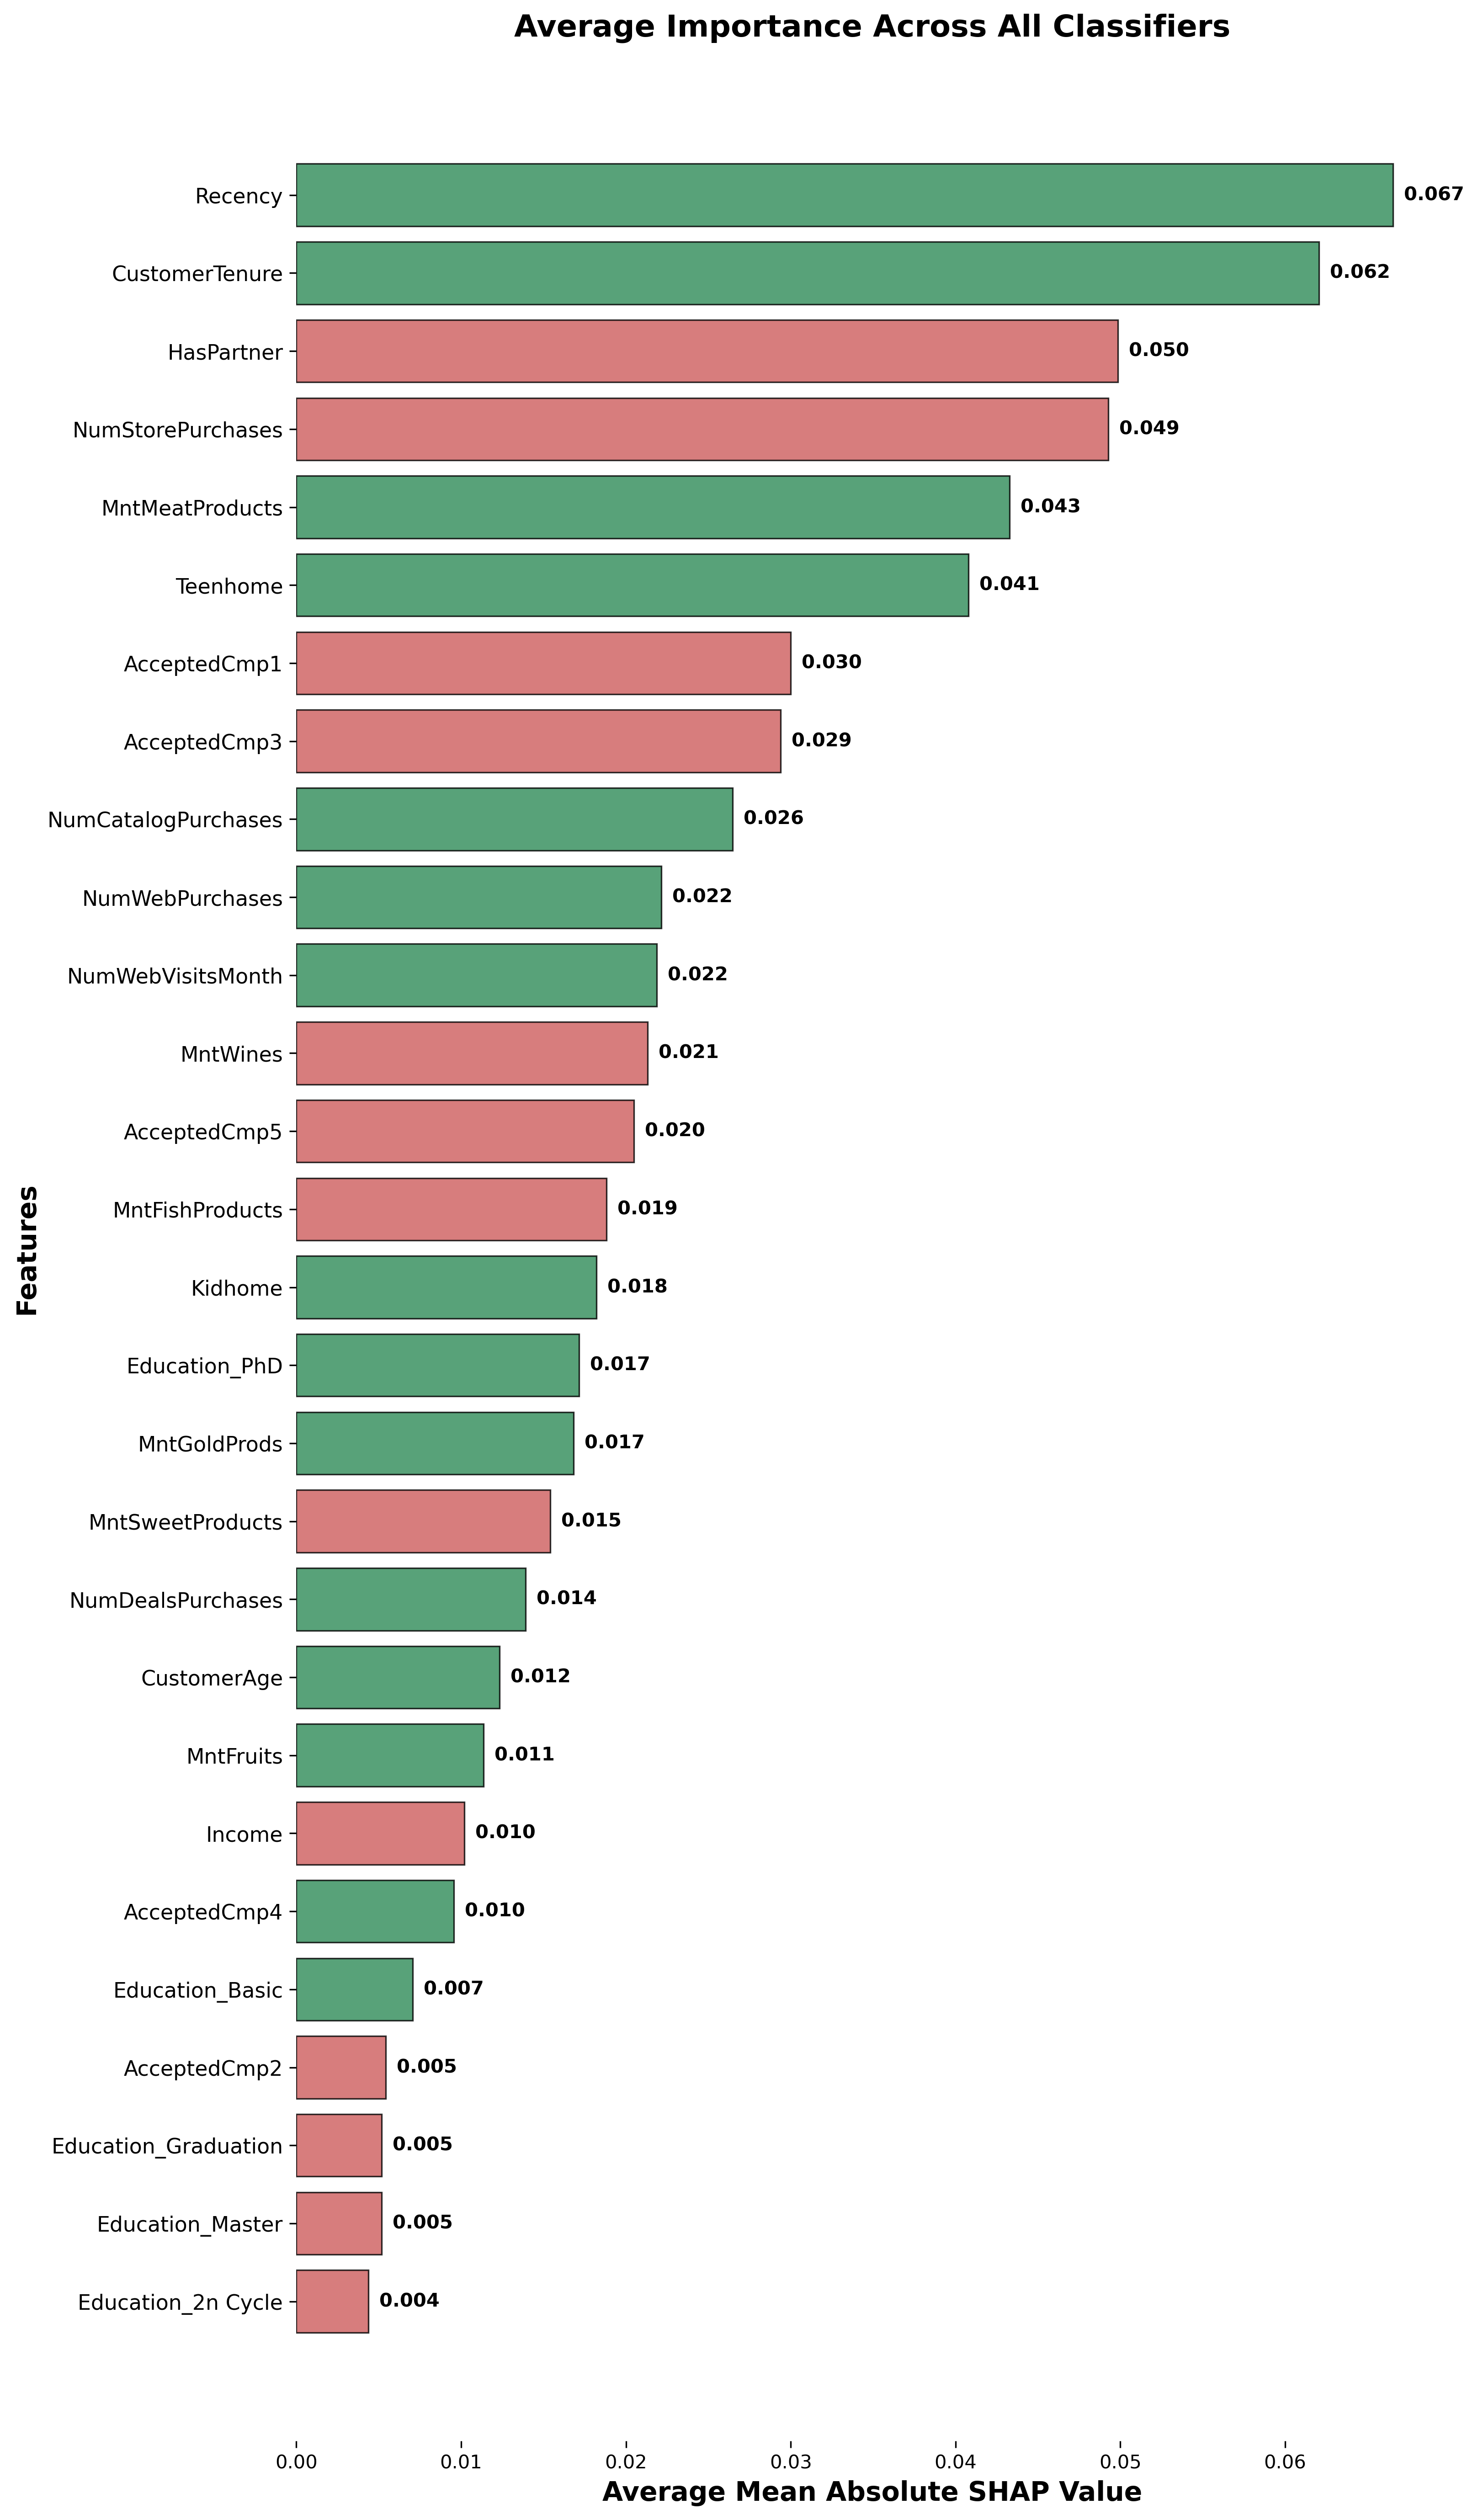

Summary plot with directional colors saved: ../reports/figures/shap_plots/feature_importance_summary_plot_directional.png

FEATURE IMPACT INTERPRETATION
Green bars: Features that positively impact the target (increase probability)
Red bars: Features that negatively impact the target (decrease probability)


In [23]:
# Create a summary table of ALL features across all classifiers
import pandas as pd

# Collect ALL features for each classifier (both absolute and directional values)
all_features_summary = {}
all_features_directional = {}

for clf_name, shap_values in shap_values_dict.items():
    # Process SHAP values
    if isinstance(shap_values, list):
        shap_values = np.sum(shap_values, axis=0)

    shap_df = pd.DataFrame(shap_values, columns=feature_names)
    mean_absolute_shap_values = shap_df.abs().mean(axis=0).sort_values(ascending=False)
    mean_shap_values = shap_df.mean(axis=0)  # Keep directional values
    
    # Drop 'Complain' if it exists
    if 'Complain' in mean_absolute_shap_values.index:
        mean_absolute_shap_values = mean_absolute_shap_values.drop('Complain')
    if 'Complain' in mean_shap_values.index:
        mean_shap_values = mean_shap_values.drop('Complain')
    
    # Get ALL features (not just top 10)
    all_features_summary[clf_name] = mean_absolute_shap_values
    all_features_directional[clf_name] = mean_shap_values

# Create summary DataFrames using ALL features from each classifier
all_features_summary = {}
all_features_directional = {}

# Collect ALL features for each classifier
for clf_name, shap_values in shap_values_dict.items():
    # Process SHAP values
    if isinstance(shap_values, list):
        shap_values = np.sum(shap_values, axis=0)

    shap_df = pd.DataFrame(shap_values, columns=feature_names)
    mean_absolute_shap_values = shap_df.abs().mean(axis=0)
    mean_shap_values = shap_df.mean(axis=0)  # Keep directional values
    
    # Drop 'Complain' if it exists
    if 'Complain' in mean_absolute_shap_values.index:
        mean_absolute_shap_values = mean_absolute_shap_values.drop('Complain')
    if 'Complain' in mean_shap_values.index:
        mean_shap_values = mean_shap_values.drop('Complain')
    
    # Store ALL features
    all_features_summary[clf_name] = mean_absolute_shap_values
    all_features_directional[clf_name] = mean_shap_values

# Create summary DataFrames with all features
summary_df = pd.DataFrame(all_features_summary)
summary_directional_df = pd.DataFrame(all_features_directional)

# Fill NaN values with 0 for features not present in some classifiers
summary_df = summary_df.fillna(0)
summary_directional_df = summary_directional_df.fillna(0)

# Calculate average importance across all classifiers
summary_df['Average'] = summary_df.mean(axis=1)
summary_directional_df['Average'] = summary_directional_df.mean(axis=1)

# Sort by average importance
summary_df = summary_df.sort_values('Average', ascending=False)
summary_directional_df = summary_directional_df.reindex(summary_df.index)  # Match the order

# Display ALL features in the summary table (not just top 15)
print("ALL Features Ranked by Average Importance Across All Classifiers")
print("=" * 80)
print(summary_df.round(4))

# Save FULL summary to CSV for easy import to Word
summary_output_path = f"{output_dir}/feature_importance_summary_all_features.csv"
summary_df.round(4).to_csv(summary_output_path)
print(f"\nFull summary table (all features) saved to: {summary_output_path}")

# Create a visualization of ALL features with directional colors
plt.figure(figsize=(12, 20))  # Increased height to accommodate all features
all_features_avg = summary_df['Average']
all_features_directional = summary_directional_df['Average']

# Create colors based on positive/negative average impact
colors = all_features_directional.apply(lambda x: '#2E8B57' if x > 0 else '#CD5C5C')  # Sea green for positive, Indian red for negative

bars = plt.barh(range(len(all_features_avg)), all_features_avg.values, 
               color=colors, edgecolor='black', linewidth=0.8, alpha=0.8)

plt.title('Average Importance Across All Classifiers', 
          fontsize=16, fontweight='bold', pad=10)  # Reduced padding from 20 to 10
plt.xlabel('Average Mean Absolute SHAP Value', fontsize=14, fontweight='bold')
plt.ylabel('Features', fontsize=14, fontweight='bold')

# Set y-axis labels with increased font size
plt.yticks(range(len(all_features_avg)), all_features_avg.index, fontsize=11)  # Increased from 9 to 11

# Add value labels with increased font size
for i, (bar, value) in enumerate(zip(bars, all_features_avg.values)):
    if value > 0.001:  # Only show labels for features with meaningful importance
        plt.text(value + 0.01 * max(all_features_avg.values), i, f'{value:.3f}', 
                va='center', ha='left', fontsize=10, fontweight='bold')  # Increased from 8 to 10

# Remove grid and frame for consistency with comparison plot
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Invert y-axis
plt.gca().invert_yaxis()

# Adjust layout with reduced spacing
plt.tight_layout()
plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.08)  # Reduce spacing between title/axis and plot

# Save the summary plot
summary_plot_path = f"{output_dir}/feature_importance_summary_plot_directional.png"
plt.savefig(summary_plot_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print(f"Summary plot with directional colors saved: {summary_plot_path}")

# Print interpretation
print("\n" + "="*60)
print("FEATURE IMPACT INTERPRETATION")
print("="*60)
print("Green bars: Features that positively impact the target (increase probability)")
print("Red bars: Features that negatively impact the target (decrease probability)")
print("="*60)